# Udacity Nanodegree: Data Science Foundations II
# Project II : Wrangling Data of WeRateDogs Twitter Account

### Student: Nelson Antonio Fernandes de Matos

## Table of Contents
<ul>
<li><a href="#introduction">Introduction</a></li>
<li><a href="#gather">Gather</a></li>
<li><a href="#assess">Assess</a></li>
<li><a href="#clean">Clean</a></li>
<li><a href="#store">Store</a></li>
<li><a href="#visualize">Visualize and Analyze</a></li>
<li><a href="#conclusion">Conclusion</a></li>    
</ul>

<a id='introduction'></a>
## Introduction

This project is a step to fulfill the requirements of Udacity's Data Science Foundation 2 Nanodegree. 

Data of <a href = "https://twitter.com/dog_rates">WeRateDogs</a> Twitter account will be gathered in three distinct ways:

* By reading the file `twitter-archive-enhanced.csv` provided by Udacity. This file contains basic tweet data.    
* By downloading the file `image_predictions.tsv` programmatically. This file contains predictions of dog's breeds based on their photos.
* By using the tweepy library to gather data from WeRateDogs Twitter account. Each JSON tweet data will be stored in a flat file, in which each line will correspond to one tweet.

All gathered data will be read into Pandas data frames. The data frames will be assessed, cleaned and stored on *.csv and *db files. 

After all, some exploratory data analyses will be performed and some visualizations will be provided using dogs ratings, number of favorites, number of retweets and breeds.

In [1]:
# Import modules:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import requests, tweepy, json, time, os
import matplotlib.pyplot as plt
%matplotlib inline

<a id='gather'></a>
## Gather

Read the file `twitter-archive-enhanced.csv` which was downloaded manually from Udacity <a href = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv">page</a>, into a Pandas dataframe.

In [2]:
twt_arch = pd.read_csv("twitter-archive-enhanced.csv")

Download programmatically, using  *requests* library, the image predicition file (`image_predictions.tsv`) hosted on Udacity's servers at the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In order to not request every time the notebook is run, the gathering will be performed only if the file image_prediction.tsv does not exist (the first time this cell is run).

In [3]:
if not (os.path.isfile("image_predicition.tsv")):
    url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
    response = requests.get(url)
    with open('image_predicition.tsv', mode='wb') as file:
        file.write(response.content)

Read the file `image_prediction.tsv` into a Pandas dataframe:

In [4]:
pred = pd.read_csv('image_predicition.tsv', sep='\t')

Use tweepy library to download all data from tweets.    
API reference page: http://docs.tweepy.org/en/v3.5.0/api.html

In [5]:
# Keys and tokens. 
# Keys, secret keys and access tokens management.

# Consumer API keys:
consumer_key = 'ZEbuEuajR54ZXo5QwdRfdqzxv' # (API key)
consumer_secret = 'lBMzS3KBocXfEurnyvP8FbEq7ezIAouIY3R8zj5kudNTy46SHH' # (API secret key)

# Access token & access token secret:
access_token = 'STUDENT_TOKEN' # (Access token)
access_secret = 'STUDENT_SECRET_TOKEN' # (Access token secret)

In order to not request Twitter servers every time the notebook is run - what would imply in a great loss of time - the gathering will be performed only if the file `tweet_json.txt` does not exist (the first time this cell is run).    
The tweet ids which return errors will be stored in a list, which will and then be saved to a file, so the data could be accessed without running all the gathering process again.

In [6]:
tweets_fails = [] # List to store ids of tweets in which tweepy returned erros.

if not (os.path.isfile("tweet_json.txt")):
    # Initialize API and some parameters:
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
    
    # Get the data
    print(">>> Gathering Twitter Data STARTED  at: {}\n".format(time.ctime()))
    with open("tweet_json.txt", 'w', encoding="utf8") as tf: # open the file tweet_json.txt
        for i, tweet_id in enumerate(twt_arch['tweet_id']):
            start = time.time() # save start time
            #
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended') # get the tweet data    
                json.dump(tweet._json, tf) # write tweet data to the file
                tf.write("\n") # jumps to the next line of the file
                status = 'SUCCESS'
            except tweepy.TweepError as err:
                status = 'FAIL'
                tweets_fails.append(tweet_id)                
            #
            end = time.time() # save end time
            elapsed = end-start # Calculate elapsed time
            print("> {:5} - tweet id: {} - elapsed time: {:2.4}s - status: {:7}"
                  .format(i, tweet_id, elapsed, status)) # Print status
            #
    print("\n>>> Gathering Twitter Data FINISHED at: {}\n".format(time.ctime()))    

In [7]:
# Write tweet ids in which a error was returned by tweepy to a file:
if (len(tweets_fails) !=0): # Check if is empty
    with open('tweets_fails.txt', 'w') as f:
        f.write('\n'.join(str(tweet_fail) for tweet_fail in tweets_fails))
else: # If is empty load from file
    with open('tweets_fails.txt', 'r') as f:
        tweets_fails = f.read().splitlines()        

In [8]:
tweets_fails

['888202515573088257',
 '873697596434513921',
 '872668790621863937',
 '869988702071779329',
 '866816280283807744',
 '861769973181624320',
 '845459076796616705',
 '842892208864923648',
 '837012587749474308',
 '827228250799742977',
 '812747805718642688',
 '802247111496568832',
 '775096608509886464',
 '770743923962707968',
 '754011816964026368',
 '680055455951884288',
 '667453023279554560']

In [9]:
tweets_list = []
tf = open('tweet_json.txt', 'r') # Open the file
for line in tf:
    try:
        tweet = json.loads(line)        
        tweets_list.append(tweet)
    except:        
        continue
tf.close()

In [10]:
twt_info = pd.DataFrame()
twt_info['tweet_id'] = [line['id'] for line in tweets_list]
twt_info['retweet_count'] = [line['retweet_count'] for line in tweets_list]
twt_info['favorite_count'] = [line['favorite_count'] for line in tweets_list]

<a id='assess'></a>
## Assess

In [11]:
# View twt_arch data frame info:
twt_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
# View twt_arch data frame:
twt_arch

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [13]:
# Chech for validity of rating_numerator:
twt_arch[(twt_arch.rating_numerator < 0)].rating_numerator.any()

False

In [14]:
# Chech for validity of rating_denominator:
twt_arch[(twt_arch.rating_denominator < 0)].rating_denominator.any()

False

In [15]:
# View ordered dogs' names:
twt_arch.name.sort_values()

1035            Abby
1021            Abby
938              Ace
1933            Acro
1327           Adele
1934           Aiden
77               Aja
480            Akumi
820               Al
875           Albert
1954          Albert
144            Albus
412            Albus
1115         Aldrick
2046       Alejandro
374        Alexander
1189    Alexanderson
486              Alf
2238           Alfie
661            Alfie
367            Alfie
1616           Alfie
858            Alfie
51              Alfy
201            Alice
1701           Alice
1495           Amber
1334         Ambrose
2078             Amy
2195          Amélie
            ...     
852               my
988              not
335              not
1747      officially
1206             old
993              one
1936             one
924              one
369              one
2326           quite
169            quite
118            quite
193            quite
2030           space
22              such
2345             the
2346         

In [16]:
# View rating_numerators:
twt_arch.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [17]:
# View rating_denominators:
twt_arch.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [18]:
# Check if tweet_id are unique:
twt_arch.tweet_id.nunique()

2356

In [19]:
# Check if there are missing images, what may be an issue for predictions:
twt_arch.expanded_urls.isnull().any()

True

In [20]:
# Check if there are missing numerators:
twt_arch.rating_numerator.isnull().any()

False

In [21]:
# Check if there are missing denominators:
twt_arch.rating_denominator.isnull().any()

False

In [22]:
# Check how many sources exists:
twt_arch.source.nunique()

4

In [23]:
# Show available sources:
set(twt_arch.source)

{'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
 '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'}

In [24]:
# Check if there are retweeted tweets:
twt_arch[twt_arch.in_reply_to_status_id.notnull()].count()

tweet_id                      78
in_reply_to_status_id         78
in_reply_to_user_id           78
timestamp                     78
source                        78
text                          78
retweeted_status_id            0
retweeted_status_user_id       0
retweeted_status_timestamp     0
expanded_urls                 23
rating_numerator              78
rating_denominator            78
name                          78
doggo                         78
floofer                       78
pupper                        78
puppo                         78
dtype: int64

In [25]:
# Check missing expanded_urls:
twt_arch[twt_arch.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


____

In [26]:
# Show pred data frame info:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
# Show pred data frame:
pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [28]:
# Show unique entries of pred data frame:
pred.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [29]:
# Check if there are predictions which are not related to a breed of dog:
pred[((pred.img_num == 1) & (pred.p1_dog == False)) |
     ((pred.img_num == 2) & (pred.p2_dog == False)) |
     ((pred.img_num == 3) & (pred.p3_dog == False))
    ].count()

tweet_id    523
jpg_url     523
img_num     523
p1          523
p1_conf     523
p1_dog      523
p2          523
p2_conf     523
p2_dog      523
p3          523
p3_conf     523
p3_dog      523
dtype: int64

____

In [30]:
twt_info

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8321,38040
1,892177421306343426,6148,32658
2,891815181378084864,4069,24583
3,891689557279858688,8468,41399
4,891327558926688256,9163,39573
5,891087950875897856,3049,19872
6,890971913173991426,2020,11619
7,890729181411237888,18463,64195
8,890609185150312448,4188,27313
9,890240255349198849,7217,31326


In [31]:
twt_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 3 columns):
tweet_id          2339 non-null int64
retweet_count     2339 non-null int64
favorite_count    2339 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


______

### Quality:
* **`twt_arch`**:    
    1-`timestamp` stored as strings.    
    2-Data frame contains retweets information.    
    3-Lower case and missing names as 'None' (column: name).¶    
    4-Tweets with no images (column: `expanded_urls`).    
    5-Missing values of dogtionary showing as 'None'.        
    6-Text difficult to read (columns `text` and `source`).        
    7-Erroneous source datatype (column `source`).    
    8-Tweet '785515384317313025': 10/10 is a date, not a rating.    
* **`pred`**:    
    9-Breeds with '-' and '_' as separators, instead of ' ' and in lower case (columns: `p1`, `p2` and `p3`).    
    10-Some predictions, with the highest confidence, are not a dog breed.    

### Tidiness:
1-Dogtionary variable stored in four columns: `doggo`, `floofer`, `pupper` and `puppo`.     
2-Not all `tweet_id` have its corresponding row in other dataframes.     
3-Three different data frames, when only one is needed.     
4-The predicted dog breed, with the highest confidence, is spread in various columns.


<a id='clean'></a>
## Clean

The requirements of this project are only to assess and clean at least **8 quality issues** and at least **2 tidiness issues** in this dataset.

In [32]:
# Make a copy of data frames to keep the originals ones.
twt_arch_clean = twt_arch.copy()
pred_clean = pred.copy()
twt_info_clean = twt_info.copy()

___
#### Quality issue 1: `timestamp` stored as strings.

#### Define
Convert `timestamp` of twt_arch data frame to pandas datetime.

#### Code

In [33]:
twt_arch_clean['timestamp'] = pd.to_datetime(twt_arch_clean.timestamp)

#### Test

In [34]:
twt_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

____
#### Quality issue 2: Data frame contains retweets information

#### Define
1 - Remove retweets using drop function.    
2 - Remove all columns, which are related to retweets, using drop function.

#### Code

In [35]:
# 1:
twt_arch_clean = twt_arch_clean[twt_arch_clean.in_reply_to_status_id.isnull()]
# 2:
columns_to_remove = ['in_reply_to_status_id', 
                     'in_reply_to_user_id', 
                     'retweeted_status_id', 
                     'retweeted_status_user_id',
                     'retweeted_status_timestamp']
twt_arch_clean.drop(columns = columns_to_remove, inplace = True)

In [36]:
twt_arch_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### Test

In [37]:
twt_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2278 non-null int64
timestamp             2278 non-null datetime64[ns]
source                2278 non-null object
text                  2278 non-null object
expanded_urls         2274 non-null object
rating_numerator      2278 non-null int64
rating_denominator    2278 non-null int64
name                  2278 non-null object
doggo                 2278 non-null object
floofer               2278 non-null object
pupper                2278 non-null object
puppo                 2278 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 231.4+ KB


____
#### Quality issue 3: Lower case and missing names as 'None' (column: `name`).

#### Define
1 - Use title function to convert the first letter to upper case.    
2 - Replace 'None' by NaN.

#### Code

In [38]:
# 1:
twt_arch_clean.name = twt_arch_clean.name.str.title()
# 2:
twt_arch_clean.name.replace('None', np.nan, inplace=True)

#### Test

In [39]:
twt_arch_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


____
#### Quality issue 4:  Tweets with no images (column: `expanded_urls`).

#### Define
Remove all rows without a expanded_urls. If there is no image, the breed prediction would be erroneous.

#### Code

In [40]:
to_drop_list = list(twt_arch_clean[twt_arch_clean.expanded_urls.isnull()].index)
twt_arch_clean.drop(to_drop_list, axis=0, inplace=True)

#### Test

In [41]:
twt_arch_clean[twt_arch_clean.expanded_urls.isnull()].any()

tweet_id              False
timestamp             False
source                False
text                  False
expanded_urls         False
rating_numerator      False
rating_denominator    False
name                  False
doggo                 False
floofer               False
pupper                False
puppo                 False
dtype: bool

____
#### Quality issue 5: Missing values of dogtionary showing as 'None'

#### Define
Replace 'None' by NaN.

#### Code

In [42]:
twt_arch_clean.doggo.replace('None', np.nan, inplace=True)
twt_arch_clean.floofer.replace('None', np.nan, inplace=True)
twt_arch_clean.pupper.replace('None', np.nan, inplace=True)
twt_arch_clean.puppo.replace('None', np.nan, inplace=True)

#### Test

In [43]:
twt_arch_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,NaN,NaN,NaN


____
#### Quality issue 6: Text difficult to read 

#### Define
Set max_colwidth, so the entire text will be displayed

#### Code

In [44]:
pd.set_option('display.max_colwidth', -1)

#### Test

In [45]:
twt_arch_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,NaN,NaN,NaN
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,NaN,NaN,NaN,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN,NaN,NaN,NaN
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,NaN,NaN,NaN


____
#### Quality issue 7: Erroneous source datatype (column `source`)

#### Define
There are only 4 different sources, all stored as string.    
1 - Abbreviate and prettify the text.    
2 - Convert to categorical datatype.

#### Code

In [46]:
# 1:
# web
twt_arch_clean.source.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
                              'web',
                              inplace=True)
# iphone
twt_arch_clean.source.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
                              'iphone',
                              inplace=True)
# vine
twt_arch_clean.source.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
                              'vine',
                              inplace=True)
# tweetdeck
twt_arch_clean.source.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
                              'tweetdeck'
                              , inplace=True)

In [47]:
# 2:
twt_arch_clean.source = twt_arch_clean.source.astype('category')

#### Test

In [48]:
set(twt_arch_clean.source)

{'iphone', 'tweetdeck', 'vine', 'web'}

In [49]:
twt_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2274 non-null int64
timestamp             2274 non-null datetime64[ns]
source                2274 non-null category
text                  2274 non-null object
expanded_urls         2274 non-null object
rating_numerator      2274 non-null int64
rating_denominator    2274 non-null int64
name                  1610 non-null object
doggo                 93 non-null object
floofer               10 non-null object
pupper                252 non-null object
puppo                 29 non-null object
dtypes: category(1), datetime64[ns](1), int64(3), object(7)
memory usage: 215.6+ KB


____
#### Quality issue 8: Tweet 785515384317313025: 10/10 is a date, not a rating

#### Define
Delete the row corresponding to tweet 785515384317313025.

#### Code

Not necessary, already fixed in quality issue 4.

#### Test

In [50]:
twt_arch_clean[twt_arch_clean.tweet_id == 785515384317313025]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


____
#### Quality issue 9: Breeds with '-' and '_' as separators, instead of ' ' and in lower case (columns: `p1`, `p2` and `p3`).    

#### Define
In columns `p1`, `p2` and `p3`:     
1-Replace '-' with ' '.    
2-Replace '_' with ' '.     
3-Use title function to convert the first letter to upper case.

#### Code

In [51]:
# 1:
pred_clean.p1 = pred_clean.p1.str.replace('_', ' ')
pred_clean.p2 = pred_clean.p2.str.replace('_', ' ')
pred_clean.p3 = pred_clean.p3.str.replace('_', ' ')

In [52]:
# 2: 
pred_clean.p1 = pred_clean.p1.str.replace('-', ' ')
pred_clean.p2 = pred_clean.p2.str.replace('-', ' ')
pred_clean.p3 = pred_clean.p3.str.replace('-', ' ')

In [53]:
# 3:
pred_clean.p1 = pred_clean.p1.str.title()
pred_clean.p2 = pred_clean.p1.str.title()
pred_clean.p3 = pred_clean.p1.str.title()

#### Test

In [54]:
pred_clean

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Welsh Springer Spaniel,0.156665,True,Welsh Springer Spaniel,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Redbone,0.074192,True,Redbone,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,German Shepherd,0.138584,True,German Shepherd,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Rhodesian Ridgeback,0.360687,True,Rhodesian Ridgeback,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Miniature Pinscher,0.243682,True,Miniature Pinscher,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese Mountain Dog,0.651137,True,Bernese Mountain Dog,0.263788,True,Bernese Mountain Dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,Box Turtle,0.933012,False,Box Turtle,0.045885,False,Box Turtle,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,Chow,0.692517,True,Chow,0.058279,True,Chow,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,Shopping Cart,0.962465,False,Shopping Cart,0.014594,False,Shopping Cart,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,Miniature Poodle,0.201493,True,Miniature Poodle,0.192305,True,Miniature Poodle,0.082086,True


____
#### Quality issue 10: Some predictions, with the highest confidence, are not a dog breed.

#### Define
1-Drop all rows in which the highest confidence prediction is not a dog breed.

#### Code

In [55]:
pred_clean = pred_clean[((pred_clean.img_num == 1) & (pred_clean.p1_dog == True)) | 
                        ((pred_clean.img_num == 2) & (pred_clean.p2_dog == True)) | 
                        ((pred_clean.img_num == 3) & (pred_clean.p3_dog == True))]

#### Test

In [56]:
pred_clean[((pred_clean.img_num == 1) & (pred_clean.p1_dog == False)) | 
           ((pred_clean.img_num == 2) & (pred_clean.p2_dog == False)) | 
           ((pred_clean.img_num == 3) & (pred_clean.p3_dog == False))]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


____
#### Tidiness issue 1: Dogtionary variable stored in four columns: `doggo`, `floofer`, `pupper` and `puppo`.

#### Define
1 - Create a column (`dogtionary`) containing 4 categories corresponding to the columns: `doggo`, `floofer`, `pupper` and `puppo`.     
2 - Drop columns: `doggo`, `floofer`, `pupper` and `puppo`.     
3 - Change `dogtionary` datatype to category.

#### Code

In [57]:
# 1:
twt_arch_clean.loc[twt_arch_clean.doggo.notnull(),'dogtionary'] = 'doggo'
twt_arch_clean.loc[twt_arch_clean.floofer.notnull(),'dogtionary'] = 'floofer'
twt_arch_clean.loc[twt_arch_clean.pupper.notnull(),'dogtionary'] = 'pupper'
twt_arch_clean.loc[twt_arch_clean.puppo.notnull(),'dogtionary'] = 'puppo'

In [58]:
# 2:
twt_arch_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

In [59]:
# 3:
twt_arch_clean.dogtionary = twt_arch_clean.dogtionary.astype('category')

#### Test

In [60]:
twt_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2274 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2274 non-null int64
timestamp             2274 non-null datetime64[ns]
source                2274 non-null category
text                  2274 non-null object
expanded_urls         2274 non-null object
rating_numerator      2274 non-null int64
rating_denominator    2274 non-null int64
name                  1610 non-null object
dogtionary            371 non-null category
dtypes: category(2), datetime64[ns](1), int64(3), object(3)
memory usage: 146.9+ KB


In [61]:
twt_arch_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dogtionary
2279,667405339315146752,2015-11-19 18:13:27,iphone,This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,NaN
1068,740373189193256964,2016-06-08 02:41:38,iphone,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,NaN,NaN
766,777684233540206592,2016-09-19 01:42:24,iphone,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",https://twitter.com/dog_rates/status/777684233540206592/photo/1,12,10,NaN,NaN
1329,705898680587526145,2016-03-04 23:32:15,iphone,Meet Max. He's a Fallopian Cephalopuff. Eyes are magical af. Lil dandruff problem. No big deal 10/10 would still pet https://t.co/c67nUjwmFs,"https://twitter.com/dog_rates/status/705898680587526145/photo/1,https://twitter.com/dog_rates/status/705898680587526145/photo/1",10,10,Max,NaN
2194,668892474547511297,2015-11-23 20:42:48,iphone,This is Ruffles. He is an Albanian Shoop Da Whoop. He just noticed the camera. Patriotic af. Classy hardwood. 11/10 https://t.co/HyDpTU5Jhj,https://twitter.com/dog_rates/status/668892474547511297/photo/1,11,10,Ruffles,NaN


____
#### Tidiness issue 2: Not all `tweet_id` have its corresponding row in other data frames.

#### Define
1-Drop from `twt_arch_clean` all tweet ids which are no present in `pred_clean`.     
2-Drop from `twt_arch_clean` all tweet ids which are no present in `twt_info_clean`.

#### Code

In [62]:
# 1:
twt_arch_clean = twt_arch_clean[twt_arch_clean.tweet_id.isin(list(pred_clean.tweet_id))]
# 2:
twt_arch_clean = twt_arch_clean[twt_arch_clean.tweet_id.isin(list(twt_info_clean.tweet_id))]

#### Test

In [63]:
twt_arch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1 to 2355
Data columns (total 9 columns):
tweet_id              1500 non-null int64
timestamp             1500 non-null datetime64[ns]
source                1500 non-null category
text                  1500 non-null object
expanded_urls         1500 non-null object
rating_numerator      1500 non-null int64
rating_denominator    1500 non-null int64
name                  1137 non-null object
dogtionary            232 non-null category
dtypes: category(2), datetime64[ns](1), int64(3), object(3)
memory usage: 97.1+ KB


____
#### Tidiness issue 3: Three different data frames, when only one is needed

#### Define
1-Merge `twt_arch_clean` and `pred_clean`.     
2-Merge the resulting `twt_arch_clean` and `twt_info_clean`.

#### Code

In [64]:
# 1:
temp = pd.merge(twt_arch_clean, pred_clean, how='left', on=['tweet_id'])
# 2:
tweets = pd.merge(temp, twt_info_clean, how='left', on=['tweet_id'])
del temp # Free up memory

In [65]:
tweets

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dogtionary,jpg_url,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,892177421306343426,2017-08-01 00:17:27,iphone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Chihuahua,0.090647,True,Chihuahua,0.068957,True,6148,32658
1,891815181378084864,2017-07-31 00:18:03,iphone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,Chihuahua,0.078253,True,Chihuahua,0.031379,True,4069,24583
2,891327558926688256,2017-07-29 16:00:24,iphone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,Basset,0.225770,True,Basset,0.175219,True,9163,39573
3,891087950875897856,2017-07-29 00:08:17,iphone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,...,0.425595,True,Chesapeake Bay Retriever,0.116317,True,Chesapeake Bay Retriever,0.076902,False,3049,19872
4,890971913173991426,2017-07-28 16:27:12,iphone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,...,0.341703,True,Appenzeller,0.199287,True,Appenzeller,0.193548,False,2020,11619
5,890729181411237888,2017-07-28 00:22:40,iphone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,...,0.566142,True,Pomeranian,0.178406,True,Pomeranian,0.076507,True,18463,64195
6,890609185150312448,2017-07-27 16:25:51,iphone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,...,0.487574,True,Irish Terrier,0.193054,True,Irish Terrier,0.118184,True,4188,27313
7,890240255349198849,2017-07-26 15:59:51,iphone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,...,0.511319,True,Pembroke,0.451038,True,Pembroke,0.029248,True,7217,31326
8,890006608113172480,2017-07-26 00:31:25,iphone,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,"https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/89000660

In [66]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 22 columns):
tweet_id              1500 non-null int64
timestamp             1500 non-null datetime64[ns]
source                1500 non-null category
text                  1500 non-null object
expanded_urls         1500 non-null object
rating_numerator      1500 non-null int64
rating_denominator    1500 non-null int64
name                  1137 non-null object
dogtionary            232 non-null category
jpg_url               1500 non-null object
img_num               1500 non-null int64
p1                    1500 non-null object
p1_conf               1500 non-null float64
p1_dog                1500 non-null bool
p2                    1500 non-null object
p2_conf               1500 non-null float64
p2_dog                1500 non-null bool
p3                    1500 non-null object
p3_conf               1500 non-null float64
p3_dog                1500 non-null bool
retweet_count         1500 no

In [67]:
tweets.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dogtionary',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'retweet_count', 'favorite_count'],
      dtype='object')

____
#### Tidiness issue 4: The predicted dog breed, with the highest confidence, is spread in various columns.

#### Define
1-Create a column (`breed`), with the highest confidence prediction.     
2-Drop: `p1`, `p2`, `p3`, `p1_dog`, `p2_dog`, `p3_dog`, `p1_conf`, `p2_conf`, `p3_conf` and `img_num`.

#### Code

In [68]:
#(tweets.iloc[0].img_num == 1) & (tweets.iloc[0].p1_conf > tweets.iloc[0].p2_conf) & (tweets.iloc[0].p1_conf > tweets.iloc[0].p3_conf)
tweets.iloc[0].p1

'Chihuahua'

In [69]:
tweets['breed']=tweets[(tweets.img_num == 1) & (tweets.p1_conf > tweets.p2_conf) & (tweets.p1_conf > tweets.p3_conf)].p1

In [70]:
# 1:
tweets.loc[(tweets.img_num == 1) & 
           (tweets.p1_conf > tweets.p2_conf) & 
           (tweets.p1_conf > tweets.p3_conf), 'breed'] = tweets.p1
#
tweets.loc[(tweets.img_num == 2) & 
           (tweets.p2_conf > tweets.p1_conf) & 
           (tweets.p2_conf > tweets.p3_conf), 'breed'] = tweets.p2
#
tweets.loc[(tweets.img_num == 3) & 
           (tweets.p3_conf > tweets.p1_conf) & 
           (tweets.p3_conf > tweets.p2_conf), 'breed'] = tweets.p3

In [71]:
# 2:
tweets.drop(columns=['p1', 'p2', 'p3', 'p1_dog', 'p2_dog', 'p3_dog', 'p1_conf', 'p2_conf', 'p3_conf', 'img_num'],
           inplace=True)

In [72]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 13 columns):
tweet_id              1500 non-null int64
timestamp             1500 non-null datetime64[ns]
source                1500 non-null category
text                  1500 non-null object
expanded_urls         1500 non-null object
rating_numerator      1500 non-null int64
rating_denominator    1500 non-null int64
name                  1137 non-null object
dogtionary            232 non-null category
jpg_url               1500 non-null object
retweet_count         1500 non-null int64
favorite_count        1500 non-null int64
breed                 1289 non-null object
dtypes: category(2), datetime64[ns](1), int64(5), object(5)
memory usage: 183.9+ KB


In [73]:
tweets.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dogtionary',
       'jpg_url', 'retweet_count', 'favorite_count', 'breed'],
      dtype='object')

In [74]:
tweets

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dogtionary,jpg_url,retweet_count,favorite_count,breed
0,892177421306343426,2017-08-01 00:17:27,iphone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,6148,32658,Chihuahua
1,891815181378084864,2017-07-31 00:18:03,iphone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,4069,24583,Chihuahua
2,891327558926688256,2017-07-29 16:00:24,iphone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,9163,39573,NaN
3,891087950875897856,2017-07-29 00:08:17,iphone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,NaN,NaN,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,3049,19872,Chesapeake Bay Retriever
4,890971913173991426,2017-07-28 16:27:12,iphone,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,NaN,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,2020,11619,Appenzeller
5,890729181411237888,2017-07-28 00:22:40,iphone,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,NaN,NaN,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,18463,64195,NaN
6,890609185150312448,2017-07-27 16:25:51,iphone,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,4188,27313,Irish Terrier
7,890240255349198849,2017-07-26 15:59:51,iphone,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status/890240255349198849/photo/1,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,7217,31326,Pembroke
8,890006608113172480,2017-07-26 00:31:25,iphone,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,"https://twitter.com/dog_rates/status/890006608113172480/photo/1,https://twitter.com/dog_rates/status/890006608113172480/photo/1",13,10,Koda,NaN,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,7179,30105,Samoyed
9,889880896479866881,2017-07-25 16:11:53,iphone,This is Bruno. He is a service shark. Only gets out of the water to assist you. 13/10 terrifyingly good boy https://t.co/u1XPQMl29g,https://twitter.com/dog_rates/status/889880896479866881/photo/1,13,10,Bruno,NaN,https://pbs.twimg.com/media/DFl99B1WsAITKsg.jpg,4873,27303,French Bulldog


<a id='store'></a>
## Store

Since all gathering, assessing and cleaning is finished, we have may store the data frame into a .csv or a .db file for use in future analysis.

#### Define:
1-Store as *.db     
2-Store as *.csv

#### Code

In [75]:
filename = 'twitter_archive_master.csv'

In [76]:
# 1:
engine = create_engine('sqlite:///twitter_archive_master.db')
tweets.to_sql('tweets', engine, index=False, if_exists='replace')

In [77]:
# 2:
tweets.to_csv('twitter_archive_master.csv', index=False)

#### Test

In [78]:
os.path.isfile('twitter_archive_master.csv') and os.path.isfile('twitter_archive_master.db')

True

<a id='visualize'></a>
## Visualize and Analyze

Since all gathering, assessing and cleaning is finished, we have a data frame suitable for analysis and visualizations.

It is mandatory to make it clear that any analysis or visualizations, without previously performing the cleaning process would result in erroneous conclusions.

#### Number of Tweets by month over time.

Analyze audience behavior (retweets and favorites) over time. The analysis will be performed in chunks of months.

In [79]:
# Separate year and month from timestamp:
tweets['year'] = tweets['timestamp'].dt.year
tweets['month'] = tweets['timestamp'].dt.month

# Create a single column with 'year_month' string.
tweets['year_month'] = tweets.year.astype('str') + '-' + tweets.month.astype('str')

In [80]:
# Create a new grouped data frame
monthly = pd.DataFrame()
monthly['tweets_count'] = tweets.groupby(['year','month'])['tweet_id'].count()
monthly['retweet_count'] = tweets.groupby(['year','month'])['retweet_count'].sum()
monthly['favorite_count'] = tweets.groupby(['year','month'])['favorite_count'].sum()

In [81]:
# Calculate by tweet:
monthly['retweet_by_tweet']=monthly['retweet_count']/monthly['tweets_count']
monthly['favorite_by_tweet']=round(monthly['favorite_count']/monthly['tweets_count'])

In [82]:
monthly

tweets_count  retweet_count  favorite_count  retweet_by_tweet  \
year month                                                                  
2015 11     190           86958          224693          457.673684         
     12     241           306271         741655          1270.834025        
2016 1      123           151990         430417          1235.691057        
     2      82            115082         323704          1403.439024        
     3      92            134476         396995          1461.695652        
     4      46            72099          214689          1567.369565        
     5      40            79458          240527          1986.450000        
     6      61            289901         699981          4752.475410        
     7      70            185604         427142          2651.485714        
     8      46            136063         402966          2957.891304        
     9      56            210478         502166          3758.535714        
     10     53            213235         589594          4023.301887        
     11     56            261008         584076          4660.857143        
     12     53            270799         738224          5109.415094        
2017 1      60            402383         988958          6706.383333        
     2      50            220816         853334          4416.320000        
     3      36            176824         741681          4911.777778        
     4      30            169539         643539          5651.300000        
     5      31            203585         834816          6567.258065        
     6      39            248236         1110383         6365.025641        
     7      44            302909         1350855         6884.295455        
     8      1             6148           32658           6148.000000        

            favorite_by_tweet  
year month                     
2015 11     1183.0             
     12     3077.0             
2016 1      3499.0             
     2      3948.0             
     3      4315.0             
     4      4667.0             
     5      6013.0             
     6      11475.0            
     7      6102.0             
     8      8760.0             
     9      8967.0             
     10     11124.0            
     11     10430.0            
     12     13929.0            
2017 1      16483.0            
     2      17067.0            
     3      20602.0            
     4      21451.0            
     5      26930.0            
     6      28471.0            
     7      30701.0            
     8      32658.0

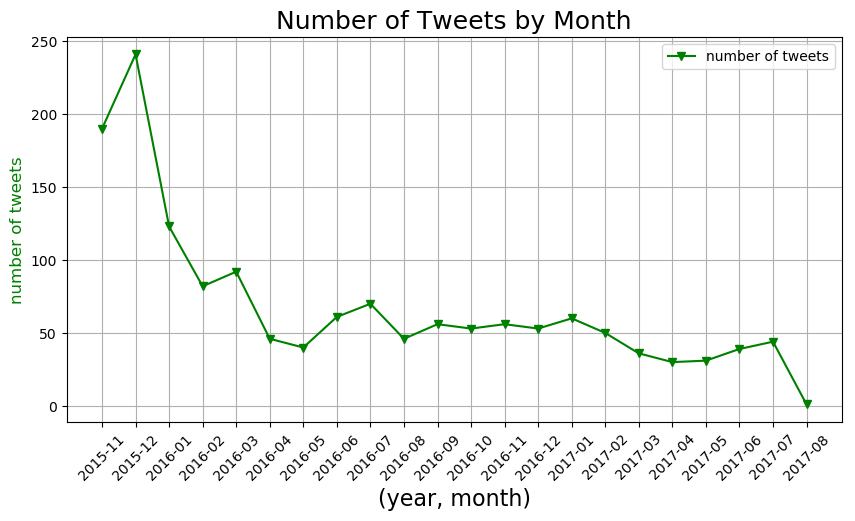

In [83]:
plt.rcdefaults() # Restore the rc params from Matplotlib's internal default style.

ax1 = monthly.tweets_count.plot(color='green',
                                marker='v',
                                grid=True,
                                label='number of tweets',
                                figsize=(10,5)) # Create the plot of first series
# Create the legend:
h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc=1)

# Cretae xticks and its labels:
ax1.set_xticks(range(len(monthly)));
ax1.set_xticklabels(["%s-%02d" % item for item in monthly.index.tolist()], rotation=45);

# Set axis labels:
ax1.set_xlabel('(year, month)', fontsize=16)
ax1.set_ylabel('number of tweets', fontsize=12, color='green')

# Set the title:
ax1.set_title('Number of Tweets by Month', fontsize=18)

plt.show()

#### Public reaction (retweets and favorites) by Tweet over time.

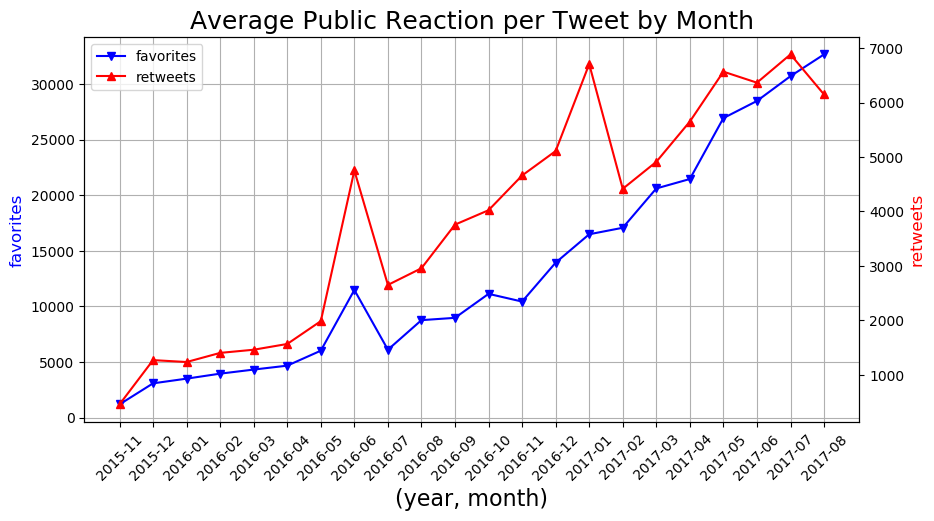

In [84]:
plt.rcdefaults() # Restore the rc params from Matplotlib's internal default style.

ax1 = monthly.favorite_by_tweet.plot(color='blue',
                                     marker='v',
                                     grid=True,
                                     label='favorites',
                                     figsize=(10,5)) # Create the plot of first series

ax2 = monthly.retweet_by_tweet.plot(color='red',
                                    marker='^',
                                    grid=True,
                                    secondary_y=True,
                                    label='retweets') # Create the plot of the second series

# Create the legend:
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2, l1+l2, loc=2)

# Cretae xticks and its labels:
ax1.set_xticks(range(len(monthly)));
ax1.set_xticklabels(["%s-%02d" % item for item in monthly.index.tolist()], rotation=45);

# Set axis labels:
ax1.set_xlabel('(year, month)', fontsize=16)
ax1.set_ylabel('favorites', fontsize=12, color='blue')
ax2.set_ylabel('retweets', fontsize=12, color='red')

# Set the title:
ax1.set_title('Average Public Reaction per Tweet by Month', fontsize=18)

plt.show()

We can see that public reaction, both retweets and favorites, has increased over time.

#### Public reaction (retweets and favorites) by Breed.

In [85]:
# Create a new data frame:
breeds = pd.DataFrame()
breeds['number_of_tweets'] = tweets.groupby('breed')['tweet_id'].count()
breeds['retweet_count'] = tweets.groupby('breed')['retweet_count'].sum()
breeds['favorite_count'] = tweets.groupby('breed')['favorite_count'].sum()
breeds['Average Rating'] = tweets.groupby('breed')['rating_numerator'].sum()/tweets.groupby('breed')['rating_denominator'].sum()

In [86]:
# Calculate by tweet:
breeds['retweet_by_tweet'] = breeds['retweet_count']/breeds['number_of_tweets'] 
breeds['favorite_by_tweet'] = breeds['favorite_count']/breeds['number_of_tweets'] 

In [87]:
breeds

,number_of_tweets,retweet_count,favorite_count,Average Rating,retweet_by_tweet,favorite_by_tweet
breed,,,,,,
Afghan Hound,4,27035,49677,1.050000,6758.750000,12419.250000
Airedale,10,11821,43737,0.950000,1182.100000,4373.700000
American Staffordshire Terrier,12,24739,88957,1.108333,2061.583333,7413.083333
Appenzeller,2,2740,14066,1.100000,1370.000000,7033.000000
Basenji,7,6253,17985,1.028571,893.285714,2569.285714
Basset,11,27319,112024,1.090909,2483.545455,10184.000000
Beagle,15,18146,56199,1.026667,1209.733333,3746.600000
Bedlington Terrier,5,13501,62543,1.000000,2700.200000,12508.600000
Bernese Mountain Dog,8,13528,59888,1.125000,1691.000000,7486.000000


In [88]:
x_val = breeds.favorite_by_tweet.tolist()
y_val = list(np.arange(len(x_val)))
labels_y = [v for v in breeds.index]
labels_x = [str(v) for v in x_val]

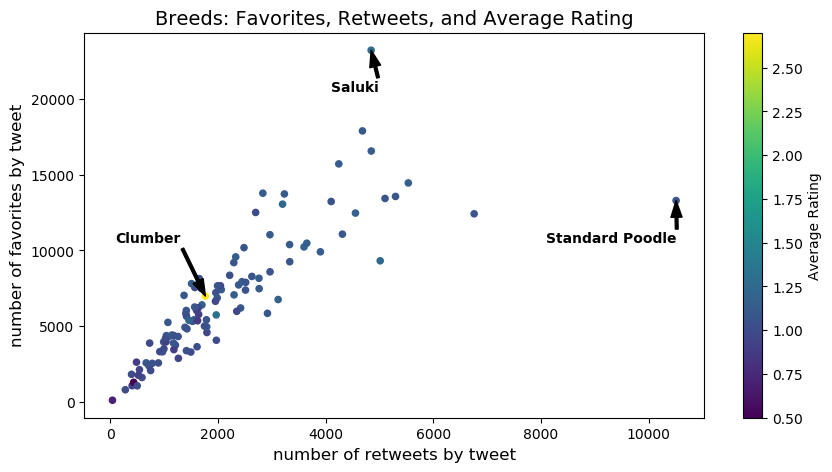

In [89]:
plt.rcdefaults() # Restore the rc params from Matplotlib's internal default style.
ax = breeds.plot.scatter(x='retweet_by_tweet', 
                         y='favorite_by_tweet', 
                         c='Average Rating', 
                         colormap='viridis',
                         figsize=(10,5),
                         grid=False)
# Set X label:
ax.set_xlabel('number of retweets by tweet', fontsize=12)
# Set Y label:
ax.set_ylabel('number of favorites by tweet', fontsize=12)
# Set the title:
ax.set_title('Breeds: Favorites, Retweets, and Average Rating', fontsize=14)

# Annotate the breed with maximum average rating:
xpos = float(breeds[breeds['Average Rating'] == breeds['Average Rating'].max()].retweet_by_tweet)
ypos = float(breeds[breeds['Average Rating'] == breeds['Average Rating'].max()].favorite_by_tweet)
breed = breeds[breeds['Average Rating'] == breeds['Average Rating'].max()].index.tolist()[0]
pos = (xpos,ypos)
ax.annotate(breed, xy=pos, xytext=(100, 10500), fontweight='bold', 
            arrowprops=dict(facecolor='black', width=2, headwidth=8))

# Annotate the breed with maximum number of retweets by tweet:
xpos = float(breeds[breeds['retweet_by_tweet'] == breeds['retweet_by_tweet'].max()].retweet_by_tweet)
ypos = float(breeds[breeds['retweet_by_tweet'] == breeds['retweet_by_tweet'].max()].favorite_by_tweet)
breed = breeds[breeds['retweet_by_tweet'] == breeds['retweet_by_tweet'].max()].index.tolist()[0]
pos = (xpos,ypos)
ax.annotate(breed, xy=pos, xytext=(8100, 10500), fontweight='bold', 
            arrowprops=dict(facecolor='black', width=2, headwidth=8))

# Annotate the breed with maximum number of favorites by tweet:
xpos = float(breeds[breeds['favorite_by_tweet'] == breeds['favorite_by_tweet'].max()].retweet_by_tweet)
ypos = float(breeds[breeds['favorite_by_tweet'] == breeds['favorite_by_tweet'].max()].favorite_by_tweet)
breed = breeds[breeds['favorite_by_tweet'] == breeds['favorite_by_tweet'].max()].index.tolist()[0]
pos = (xpos,ypos)
ax.annotate(breed, xy=pos, xytext=(4100, 20500), fontweight='bold', 
            arrowprops=dict(facecolor='black', width=2, headwidth=8));

In [90]:
breeds[breeds['Average Rating'] == breeds['Average Rating'].max()]

,number_of_tweets,retweet_count,favorite_count,Average Rating,retweet_by_tweet,favorite_by_tweet
breed,,,,,,
Clumber,1,1767,6984,2.7,1767.0,6984.0


In [91]:
xpos = float(breeds[breeds['Average Rating'] == breeds['Average Rating'].max()].retweet_by_tweet)
ypos = float(breeds[breeds['Average Rating'] == breeds['Average Rating'].max()].favorite_by_tweet)
pos = (xpos,ypos)

<a id='conclusion'></a>
## Conclusion

All data was gathered, assessed an cleaned. The analysis was performed and some visualizations were provided. Everything is better described in the file `wrangle_report.pdf`. The file `act_report.pdf` conveys the insights obtained from visualizations.